In [1]:
import numpy as np
import torch
from torch import nn  
import time 
import os  
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [34]:
## import self defined functions
from sys import path 
# insert at 1, 0 is the script path (or '' in REPL)
path.insert(1, '/tigress/cw55/local/python_lib')
from cg_funcs import global_mean_xarray
root = '/tigress/cw55/work/2022_radi_nn/NN_AM4'
path.insert(1,  root+'/work')
import work.sw_csaf_Li5Relu_cluster.train_script as swcsaf
import work.sw_af_Li5Relu.train_script00 as swaf

In [3]:
plt.rcParams['font.size'] = '8'

In [4]:
from get_AM4_data_sw import get_AM4_data_sw_coords
######################################################
# common functions to split the training and test data
from NNRTMC_lw_utils import  split_train_test_sample, \
draw_batches, data_std_normalization_sw, print_key_results, return_exp_dir
    

In [5]:
if __name__ == '__main__': 
    torch.cuda.set_device(0) # select gpu_id, default 0 means the first GPU
    device = f'cuda:{torch.cuda.current_device()}'
    ######################################################
    # set exp name and runs
    Exp_name = [
        'sw_csaf_Li5Relu_cluster',
        'sw_af_Li5Relu',
    ]
    Exp_name_model_dict = {
        'sw_csaf_Li5Relu_cluster': swcsaf,
        'sw_af_Li5Relu': swaf
    }
    sky_cond = {
        'sw_csaf_Li5Relu_cluster': 'csaf',
        'sw_af_Li5Relu': 'af',
    }
    work_dir = root+'/work/' 
    # file list from AM4 runs
    out_filelist = [f'/scratch/gpfs/rm5768/ml/20000101.fluxes.tile{_}.nc' for _ in range(1,7)]
    inp_filelist = [f'/scratch/gpfs/rm5768/ml/20000101.new_offline_input.tile{_}.nc' for _ in range(1,7)]
    hybrid_p_sigma_para = xr.open_dataset('/tigress/cw55/data/NNRTMC_dataset/AM4_pk_bk_202207.nc')
    A_k = hybrid_p_sigma_para.ak.values[None,:]
    B_k = hybrid_p_sigma_para.bk.values[None,:] 

In [6]:
predi = {}
error = {}
NN_model = {}
ds_regrid = {}
for mo in Exp_name:
    ######################################################
    run_num, exp_dir = return_exp_dir(work_dir, mo, create_dir=False)
    # load restart file
    PATH_last =  exp_dir+f'/restart.{run_num-1:02d}.pth'
    restart_data = torch.load(PATH_last)  # load exist results and restart training
    print(f'load: {PATH_last}')
    # read training dataset, nor_para, model parameteres
    nor_para = restart_data['nor_para']
    model_state_dict = restart_data['model_state_dict'] 
    
    # read data
    input_array_ori, output_array_ori, ds_coords = \
    get_AM4_data_sw_coords(out_filelist, inp_filelist, condition=sky_cond[mo], month_sel = None, day_sel = [15,20,25]) 
    # initialize model
    if mo == 'sw_af_Li5Relu':
        NN_model[mo] = Exp_name_model_dict[mo].ResNNRTMC(device, nor_para, A_k, B_k, input_array_ori.shape[1],model_state_dict)  
    else:
        NN_model[mo] = Exp_name_model_dict[mo].ResNNRTMC(device, nor_para, A_k, B_k, model_state_dict)  
    
    # remove data that rsdt == 0 (night, no shortwave transfer) 
    day_ind = np.argwhere(~np.isclose(input_array_ori[:,-1],0,rtol=1e-05, atol=1e-2,)).squeeze()
    # normalize data via saved nor_para in restart file
    nor_para, input_array, output_array   = data_std_normalization_sw(input_array_ori[day_ind], output_array_ori[day_ind], nor_para)
    ######################################################
    # move all data to GPU
    input_torch = torch.tensor(input_array, dtype=torch.float32).to(device)
    output_torch = torch.tensor(output_array, dtype=torch.float32).to(device) 

    # get output from NN
    predi[mo] = np.zeros_like(output_array_ori)
    predi[mo][day_ind]   = NN_model[mo].predict(input_torch).cpu().numpy() 
    # denormalize
    predi[mo][day_ind] = predi[mo][day_ind]/nor_para['output_scale'] + nor_para['output_offset'] 
    error[mo] = predi[mo] - output_array_ori
    time    = ds_coords[0]['time']
    pfull   = ds_coords[0]['pfull']
    grid_yt = ds_coords[0]['grid_yt']
    grid_xt = ds_coords[0]['grid_xt']
    txy_size = time.shape[0]*grid_xt.shape[0]*grid_yt.shape[0]

    if (predi[mo].shape[0]/txy_size) !=6:
        raise Exception('wrong size of output, pls check data dimension')
    NN_output_name = 'NN_20000101.fluxes' 
    subprocess.run([f'mkdir -p {exp_dir}/NN_pred'], shell=True, check=True)
    for i in range(6):
        output_nn_ti = predi[mo][txy_size*i:txy_size*(i+1)]
        output_nn_ti = output_nn_ti.reshape(time.shape[0],
                                            grid_yt.shape[0],
                                            grid_xt.shape[0],
                                            -1)
        output_err_ti = error[mo][txy_size*i:txy_size*(i+1)]
        output_err_ti = output_err_ti.reshape(time.shape[0],
                                            grid_yt.shape[0],
                                            grid_xt.shape[0],
                                            -1)
        ds = xr.Dataset( 
                        {'rsut':  (["time","grid_xt", "grid_yt"], output_nn_ti[:,:,:,0]),
                         'rsds':      (["time","grid_xt", "grid_yt"], output_nn_ti[:,:,:,1]),
                         'rsus':  (["time","grid_xt", "grid_yt"], output_nn_ti[:,:,:,2]),
                         'tntrs': (["time","grid_xt", "grid_yt", "pfull"], output_nn_ti[:,:,:,3:]),
                         'err_rsut':  (["time","grid_xt", "grid_yt"], output_err_ti[:,:,:,0]),
                         'err_rsds':      (["time","grid_xt", "grid_yt"], output_err_ti[:,:,:,1]),
                         'err_rsus':  (["time","grid_xt", "grid_yt"], output_err_ti[:,:,:,2]),
                         'err_tntrs': (["time","grid_xt", "grid_yt", "pfull"], output_err_ti[:,:,:,3:])
                        },
                        coords=ds_coords[i]
                       )
        var_4d_name = ['tntrs', 'err_tntrs']
        var_3d_name = ['rsut', 'rsds','rsus',
                       'err_rsut', 'err_rsds','err_rsus']
        for _var in var_4d_name:
            ds[_var] = ds[_var].transpose("time", "pfull","grid_yt", "grid_xt")
        for _var in var_3d_name:
            ds[_var] = ds[_var].transpose("time",  "grid_yt", "grid_xt")
        encoding={}
        for _var in list(ds.keys()):
            encoding[_var] = {"dtype":"float32", "_FillValue":None} 
        ds.to_netcdf(exp_dir+f'/NN_pred/{NN_output_name}.tile{i+1}.nc', encoding=encoding)
        var_list = list(ds.keys())
        ds.close()
    # run fregrid in subshell
    var_list_str = ','.join(var_list)
    cmd = f"cd {exp_dir}/NN_pred;"\
         +f"cp {root}/regrid/* . ;"\
         +f"bash run_fregrid.sh {NN_output_name} {var_list_str};"\
         +f"rm {NN_output_name}.tile*"
    tmp=subprocess.run([cmd], shell=True, capture_output=True)
    if tmp.stderr.decode("utf-8") != '': 
        raise Exception(tmp.stderr.decode("utf-8")) 
    # print(tmp.stdout.decode("utf-8"))
    # open regridded file
    with  xr.open_dataset(exp_dir+f'/NN_pred/{NN_output_name}.nc') as ds:
        ds_regrid[mo] = ds.load()
    torch.cuda.empty_cache()

load: /tigress/cw55/work/2022_radi_nn/NN_AM4/work/sw_csaf_Li5Relu_cluster/restart.05.pth
Data selection:
Month: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] 
Day: [15]
Total data size: 2757547
load: /tigress/cw55/work/2022_radi_nn/NN_AM4/work/sw_af_Li5Relu/restart.04.pth
Data selection:
Month: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] 
Day: [15]
Total data size: 2757547


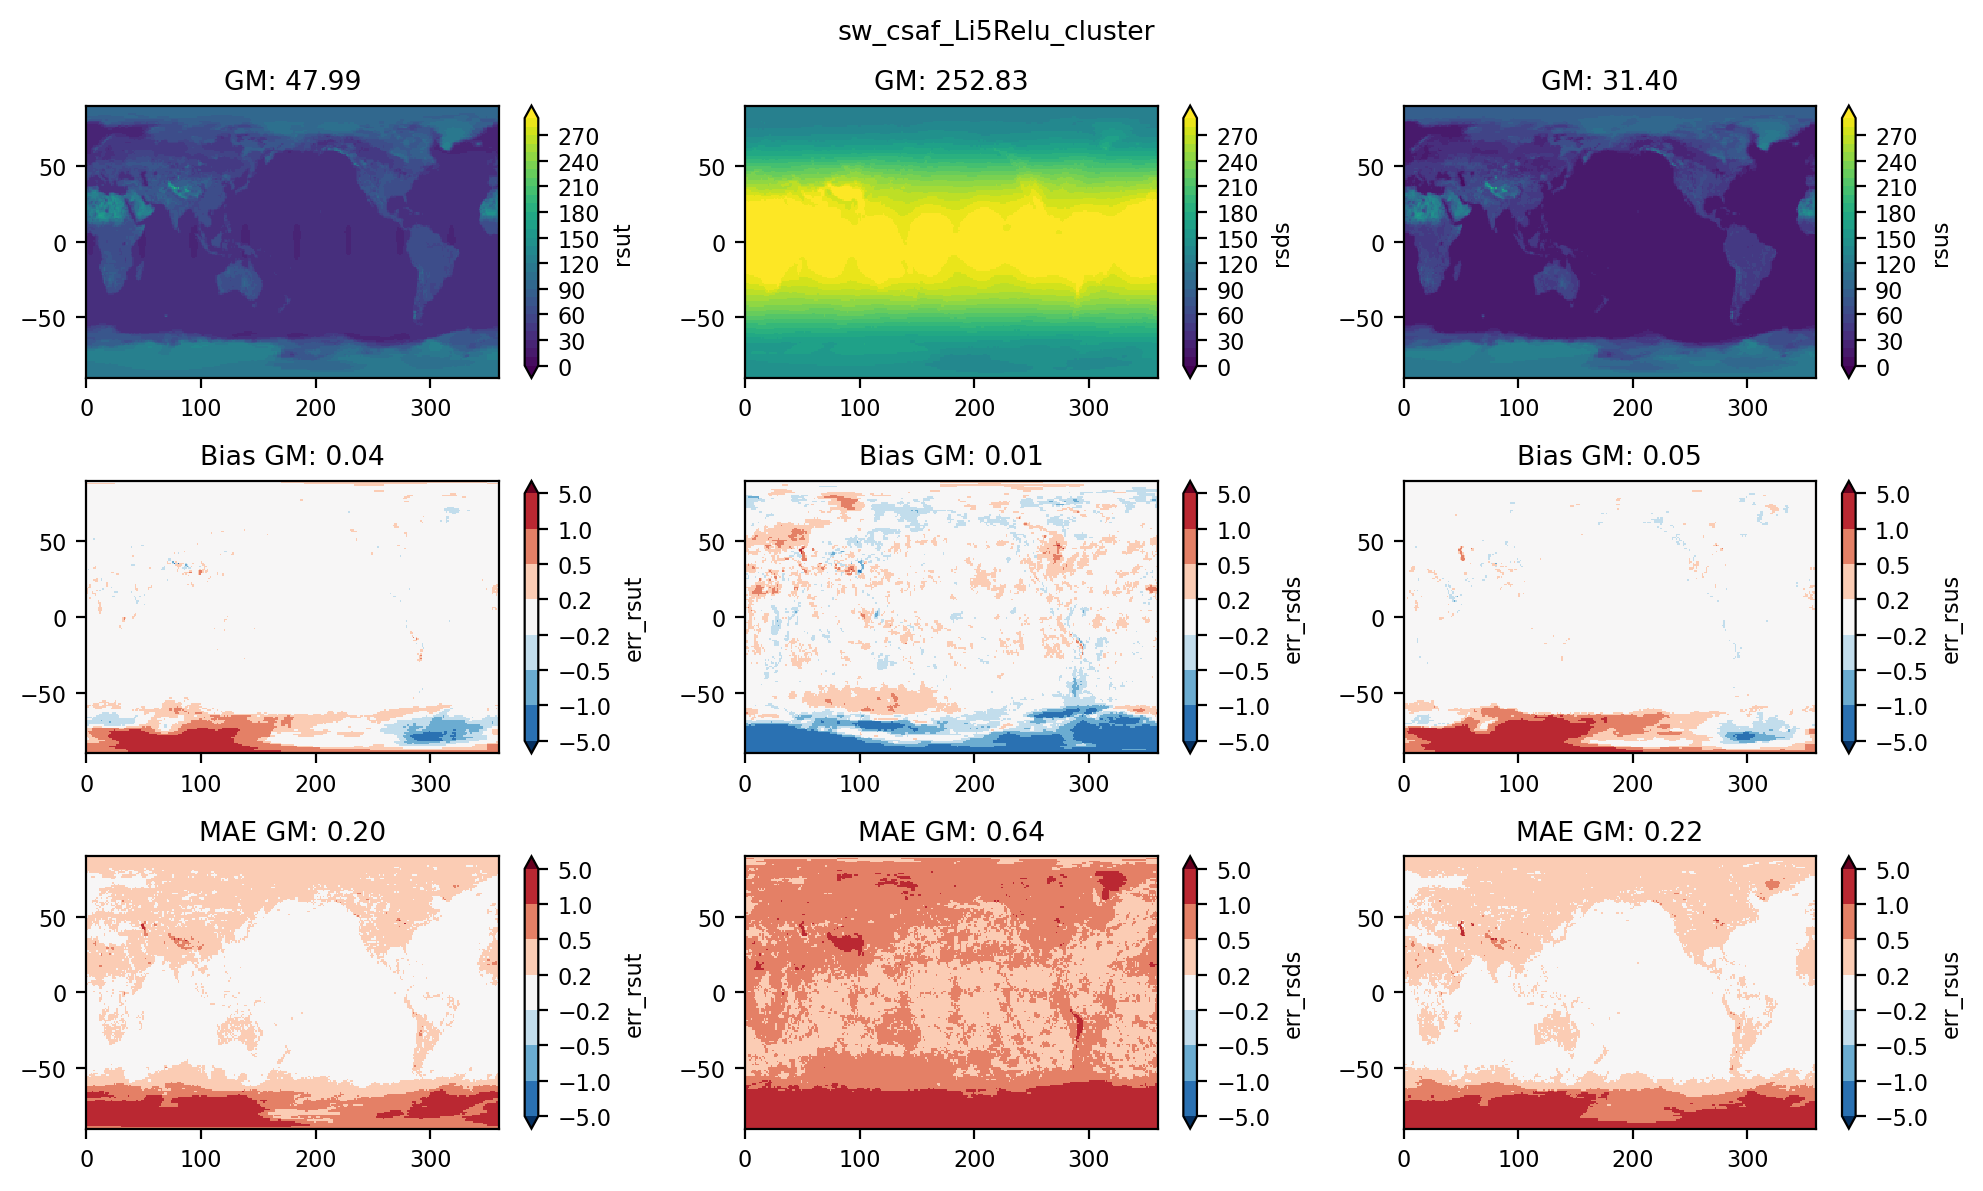

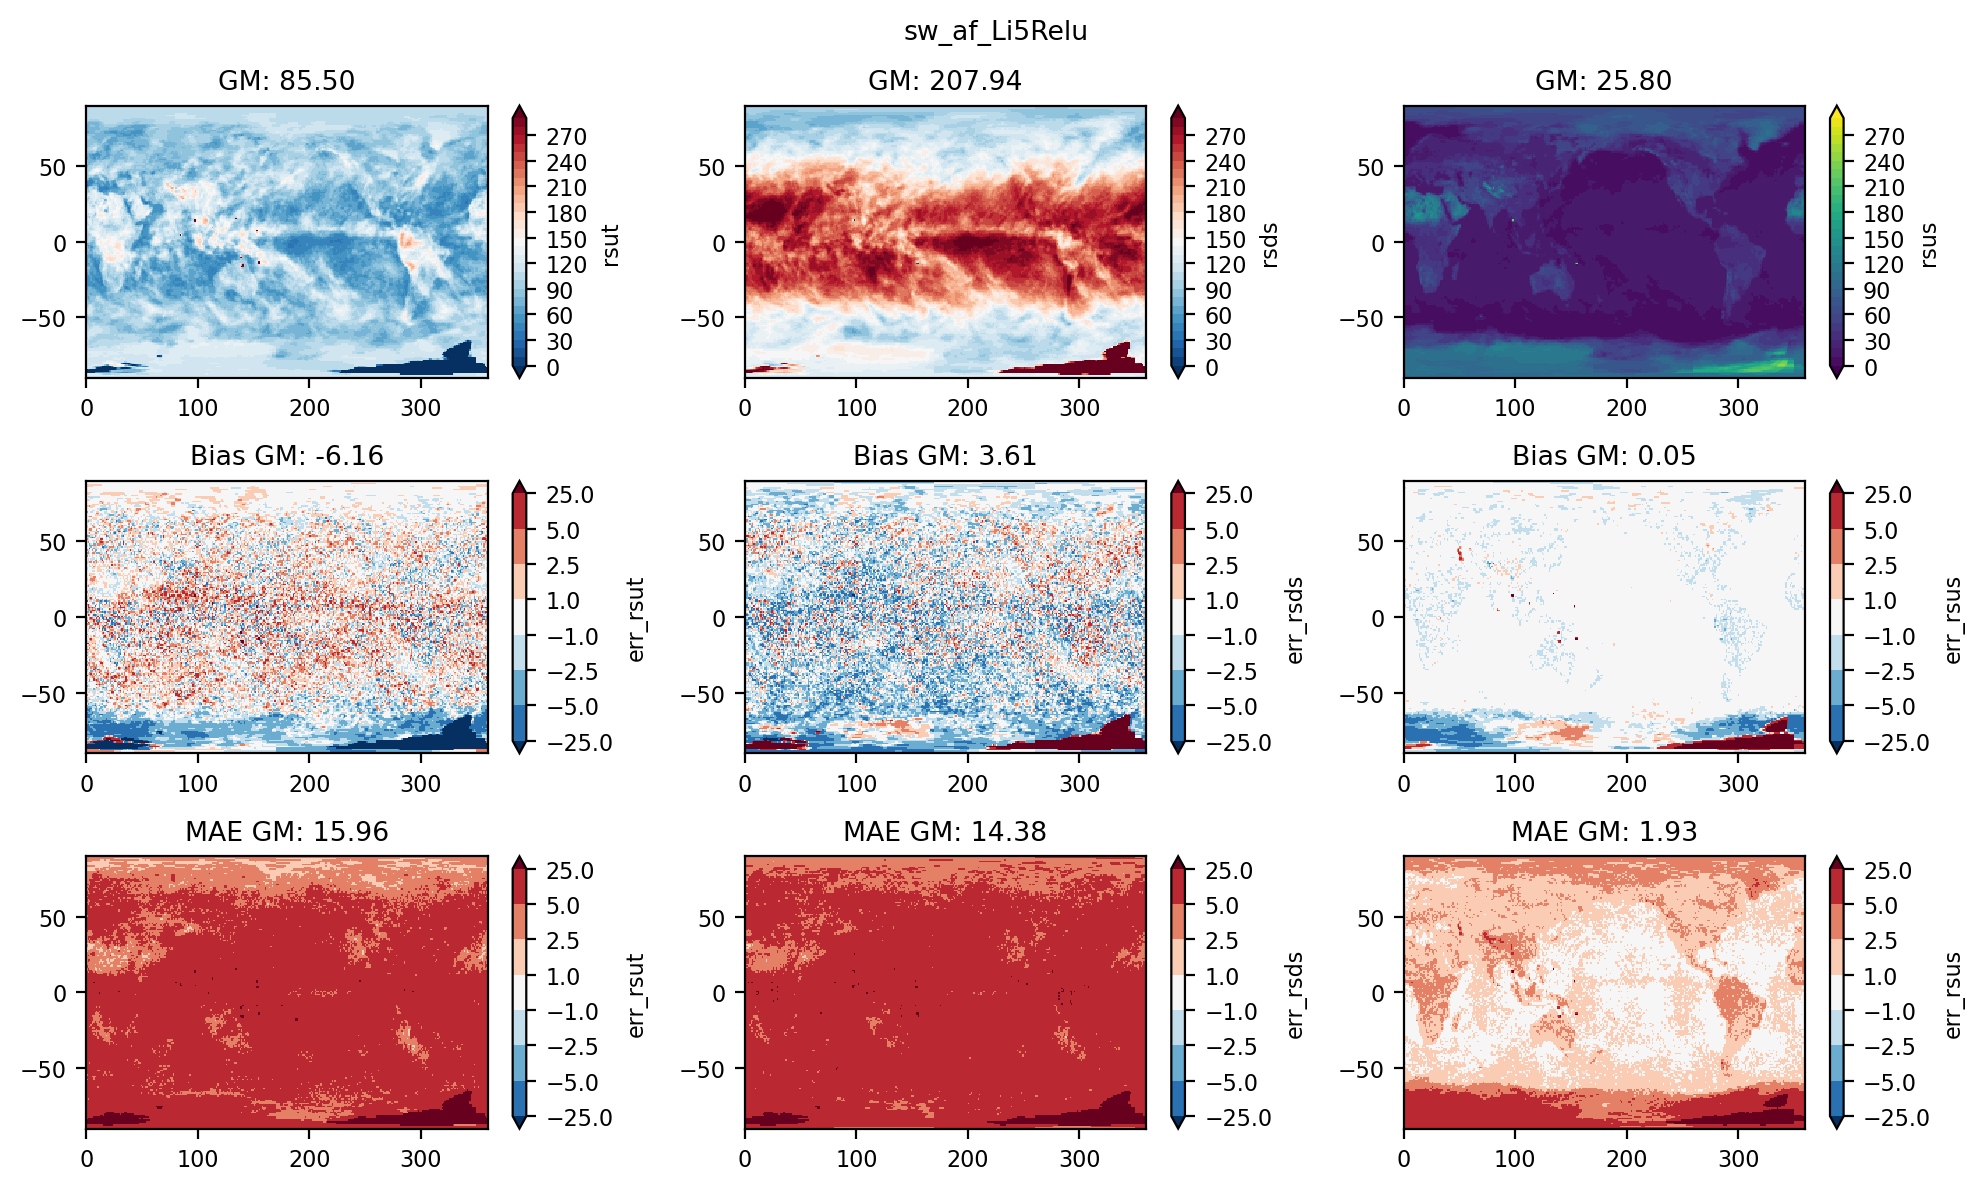

In [48]:
for mo in Exp_name:
    ds_plot = ds_regrid[mo].rename({'grid_yt':'lat', 'grid_xt':'lon'})
    fig, axs = plt.subplots(nrows=3,ncols=3,figsize=(10,6),dpi=200)
    axs = axs.flatten()
    var1 = ['rsut','rsds','rsus']
    level = np.arange(0,300,10)
    for i in range(3):
        ax=axs[i]
        da = ds_plot[var1[i]].mean('time')
        da.plot(ax=ax, levels=level, extend='both') 
        ax.set_title(f'GM: {global_mean_xarray(da).values:4.2f}')
    level = np.array([-5,-1,-0.5,-0.2,0.2,0.5,1,5])
    if mo == 'sw_af_Li5Relu': level = level*5
    for i in range(3):
        ax=axs[i+3]
        da = ds_plot['err_'+var1[i]].mean('time')
        da.plot(ax=ax, levels=level, extend='both')   
        ax.set_title(f'Bias GM: {global_mean_xarray(da).values:4.2f}')
    for i in range(3):
        ax=axs[i+6]
        da = abs(ds_plot['err_'+var1[i]]).mean('time')
        da.plot(ax=ax, levels=level, extend='both')   
        ax.set_title(f'MAE GM: {global_mean_xarray(da).values:4.2f}') 
    for ax in axs:
        ax.set(xlabel=None,ylabel=None)
    plt.suptitle(mo)
    fig.tight_layout()